# **Import all the needed library**

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Machine learning models and utilities
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Sparse matrix operations
from scipy.sparse import hstack, csr_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sb

 # **Import the data from csv file**

In [ ]:
#Read csv file
book_data_balanced = pd.read_csv("book_data_balanced.csv")
book_data_balanced.info()
book_data_balanced.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10186 entries, 0 to 10185
Data columns (total 41 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   asin                                        10186 non-null  object 
 1   title                                       10186 non-null  object 
 2   author                                      10186 non-null  object 
 3   stars                                       10186 non-null  float64
 4   price                                       10186 non-null  float64
 5   isKindleUnlimited                           10186 non-null  bool   
 6   category_id                                 10186 non-null  int64  
 7   isBestSeller                                10186 non-null  bool   
 8   isEditorsPick                               10186 non-null  bool   
 9   isGoodReadsChoice                           10186 non-null  bool   
 10  top_author

,asin,title,author,stars,price,isKindleUnlimited,category_id,isBestSeller,isEditorsPick,isGoodReadsChoice,...,category_name_Politics & Social Sciences,category_name_Reference,category_name_Religion & Spirituality,category_name_Romance,category_name_Science & Math,category_name_Science Fiction & Fantasy,category_name_Self-Help,category_name_Sports & Outdoors,category_name_Teen & Young Adult,category_name_Travel
0,B0CFWMH8RB,Reframe Your Brain: The User Interface for Hap...,Scott Adams,4.8,9.99,False,27,True,False,False,...,False,False,False,False,False,False,False,False,False,False
1,B0B9BCP7LP,The Peking Express: The Bandits Who Stole a Tr...,James M Zimmerman,4.5,3.99,False,9,True,False,False,...,False,False,False,False,False,False,False,False,False,False
2,B0CBWJKK4W,Amish Harvest Time: Amish Romance (The Amish B...,Samantha Price,4.7,4.99,True,5,True,False,False,...,False,False,False,False,False,False,False,False,False,False
3,B0B6GNP833,The Bones at Point No Point (A Thomas Austin C...,D.D. Black,4.4,4.99,True,21,True,False,False,...,False,False,False,False,False,False,False,False,False,False
4,B09MDRQB5P,Quantum Physics For Beginners: The Simple Guid...,Jeremy Wooster,4.3,9.99,True,11,True,False,False,...,False,False,False,False,False,False,False,False,False,False


---

# **Hyperparameter Tuning for Decision Tree**

## **What We're Doing:**
1. **Objective**:
   - Optimize the parameters of the Random Forest Classifier (`n_estimators` and `max_depth`) to achieve the best accuracy for predicting bestseller status.

2. **Hyperparameter Grid**:
   - **`n_estimators`**: Represents the number of trees in the Random Forest, ranging from 100 to 1000 in increments of 100.
   - **`max_depth`**: Indicates the maximum depth of trees, evaluated from 2 to 10.

3. **Cross-Validation**:
   - **5-fold CV**: Ensures robust evaluation by splitting the training data into 5 subsets, training on 4 subsets, and validating on the remaining 1, repeated 5 times.
   - **Scoring Metric**: Accuracy is used to assess model performance.

4. **Training the GridSearchCV**:
   - `hpGrid.fit(X_train_combined, y_train)`: Trains Random Forest models across all combinations of `n_estimators` and `max_depth` specified in the grid.

\

## **Expected Results:**
- **Best Parameters**:
  - `hpGrid.best_params_` will reveal the optimal values for `n_estimators` and `max_depth`.
- **Best Accuracy**:
  - `hpGrid.best_score_` provides the highest cross-validated accuracy achieved during tuning.

In [ ]:
# Extract response and predictor variables
X_text = book_data_balanced['title']
X_other = book_data_balanced.drop(columns=['asin', 'title', 'author', 'isKindleUnlimited', 'category_id',
                                           'isBestSeller', 'isEditorsPick', 'isGoodReadsChoice'])
y = book_data_balanced['isBestSeller']

# Split the dataset into training and testing sets
X_text_train, X_text_test, X_other_train, X_other_test, y_train, y_test = train_test_split(X_text, X_other, y, test_size=0.2)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

X_other_train = X_other_train.astype(int)
X_other_test = X_other_test.astype(int)

# Convert numeric features to sparse matrices
X_other_train_sparse = csr_matrix(X_other_train.values)
X_other_test_sparse = csr_matrix(X_other_test.values)

# Combine text and numeric features
X_train_combined = hstack([X_text_train_tfidf, X_other_train_sparse])
X_test_combined = hstack([X_text_test_tfidf, X_other_test_sparse])

In [ ]:
# Define the Hyper-parameter Grid to search on, in case of Random Forest
param_grid = {'n_estimators': np.arange(100,1001,100),
              'max_depth': np.arange(2, 11)}

# Create the Hyper-parameter Grid
hpGrid = GridSearchCV(RandomForestClassifier(),
                      param_grid,
                      cv = 5,
                      scoring = 'accuracy')

# Train the models using Cross-Validation
hpGrid.fit(X_train_combined, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
             scoring='accuracy')

In [ ]:
# Print the parameters and score (accuracy) of the best Model after CV
print(hpGrid.best_estimator_)
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=np.int64(10), n_estimators=np.int64(800))
0.7299929574016956


# **Model 7: Random Forest with parameters based on GridSearchCV**

## **I. Data Preparation:**
- **Response and Predictors:**
   - Predictors:
   > `Title`\
   > `Author`\
   > `Genre`\
   > `Star rating`\
   > `Price`
   - Response: `isBestSeller`.

- **Train-Test Split**:
   - Dataset split: **80% training**, **20% testing**, ensuring robust evaluation.

- **TF-IDF Vectorization**:
   - Text data (`title`) is transformed into numeric features using the **TF-IDF** method.
   - Sparse matrices are created for numeric features for efficiency.

## **II. Model Training:**
- **Feature Combination**:
   - Features are combined into a single matrix for training and testing.

- **Random Forest**:
   - Use **Random Forest** to train predictors to give the response.


This workflow ensures efficient data handling, feature engineering, and meaningful visualization for interpreting the classification model.

In [ ]:
# Extract response and predictor variables
X_text = book_data_balanced['title']
X_other = book_data_balanced.drop(columns=['asin', 'title', 'author', 'isKindleUnlimited', 'category_id',
                                           'isBestSeller', 'isEditorsPick', 'isGoodReadsChoice'])
y = book_data_balanced['isBestSeller']

# Split the dataset into training and testing sets
X_text_train, X_text_test, X_other_train, X_other_test, y_train, y_test = train_test_split(X_text, X_other, y, test_size=0.2)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
X_text_train_tfidf = vectorizer.fit_transform(X_text_train)
X_text_test_tfidf = vectorizer.transform(X_text_test)

X_other_train = X_other_train.astype(int)
X_other_test = X_other_test.astype(int)

# Convert numeric features to sparse matrices
X_other_train_sparse = csr_matrix(X_other_train.values)
X_other_test_sparse = csr_matrix(X_other_test.values)

# Combine text and numeric features
X_train_combined = hstack([X_text_train_tfidf, X_other_train_sparse])
X_test_combined = hstack([X_text_test_tfidf, X_other_test_sparse])

In [ ]:
# Create the Random Forest object
rforest = RandomForestClassifier(n_estimators = 800,
                                 max_depth = 10)

# Fit Random Forest on Train Data
rforest.fit(X_train_combined, y_train.ravel())

<ipython-input-76-a2eb83fb8504>:6: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  rforest.fit(X_train_combined, y_train.ravel())


RandomForestClassifier(max_depth=10, n_estimators=800)

# **Checking accuracy**

After training the Random Forest (max depth = 10, number of trees = 800) model, we will check the accuracy for training dataset and testing dataset

##  **I. Train Data Analysis**

We will use confusion matrix to check:
- Accuracy
- True Positive Rate
- True Negative Rate
- False Positive Rate
- False Negative Rate

Train Data
Accuracy  :	 0.788659793814433

TPR Train :	 0.7981942410932162
TNR Train :	 0.7790123456790123

FPR Train :	 0.22098765432098766
FNR Train :	 0.2018057589067838


<Axes: >

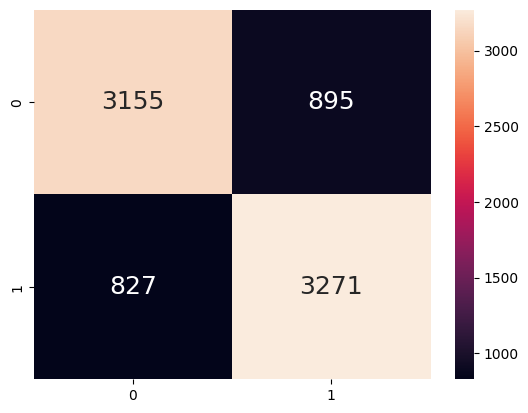

In [ ]:
# Predict the Response corresponding to Predictors
y_train_pred = rforest.predict(X_train_combined)

# Print the Classification Accuracy
print("Train Data")
print("Accuracy  :\t", rforest.score(X_train_combined, y_train))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTrain = confusion_matrix(y_train, y_train_pred)
tpTrain = cmTrain[1][1] # True Positives : Good (1) predicted Good (1)
fpTrain = cmTrain[0][1] # False Positives : Bad (0) predicted Good (1)
tnTrain = cmTrain[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTrain = cmTrain[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Train :\t", (tpTrain/(tpTrain + fnTrain)))
print("TNR Train :\t", (tnTrain/(tnTrain + fpTrain)))
print()

print("FPR Train :\t", (fpTrain/(tnTrain + fpTrain)))
print("FNR Train :\t", (fnTrain/(tpTrain + fnTrain)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_train, y_train_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### **Confusion Matrix:**
- **True Negatives (TN)**: 3155 books were correctly classified as non-bestsellers.
- **True Positives (TP)**: 3271 books were correctly identified as bestsellers.
- **False Negatives (FN)**: 827 bestsellers were misclassified as non-bestsellers.
- **False Positives (FP)**: 895 non-bestsellers were misclassified as bestsellers.

### **Key Metrics:**
1. **Accuracy**:
   - The model achieved an accuracy of **78.87%**, reflecting high overall correctness in predictions.
2. **True Positive Rate (TPR)**:
   - **79.82%**, indicating that model 7 have improve in predicting bestseller books comparing to model 4.
3. **True Negative Rate (TNR)**:
   - **77.90%**, indicating that model 7 have improve in predicting non bestseller books comparing to model 4.
4. **False Positive Rate (FPR)**:
   - **22.10%**, highlighting acceptable misclassification of non-bestsellers.
5. **False Negative Rate (FNR)**:
   - **20.18%**, highlighting acceptable misclassification of bestsellers.

## **II. Test Data Analysis**

We will use confusion matrix to check:
- Accuracy
- True Positive Rate
- True Negative Rate
- False Positive Rate
- False Negative Rate

Test Data
Accuracy  :	 0.7423945044160942

TPR Test :	 0.7678391959798995
TNR Test :	 0.7181208053691275

FPR Test :	 0.28187919463087246
FNR Test :	 0.2321608040201005


<Axes: >

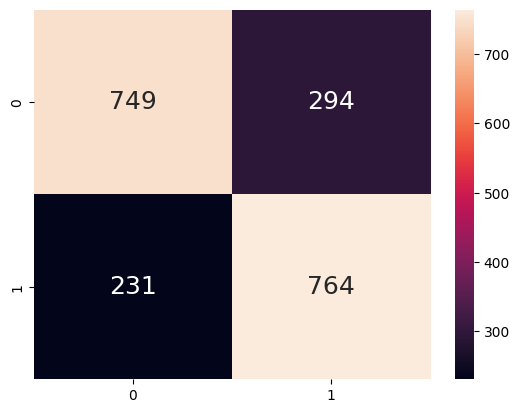

In [ ]:
# Predict the Response corresponding to Predictors
y_test_pred = rforest.predict(X_test_combined)

# Print the Classification Accuracy
print("Test Data")
print("Accuracy  :\t", rforest.score(X_test_combined, y_test))
print()

# Print the Accuracy Measures from the Confusion Matrix
cmTest = confusion_matrix(y_test, y_test_pred)
tpTest = cmTest[1][1] # True Positives : Good (1) predicted Good (1)
fpTest = cmTest[0][1] # False Positives : Bad (0) predicted Good (1)
tnTest = cmTest[0][0] # True Negatives : Bad (0) predicted Bad (0)
fnTest = cmTest[1][0] # False Negatives : Good (1) predicted Bad (0)

print("TPR Test :\t", (tpTest/(tpTest + fnTest)))
print("TNR Test :\t", (tnTest/(tnTest + fpTest)))
print()

print("FPR Test :\t", (fpTest/(fpTest + tnTest)))
print("FNR Test :\t", (fnTest/(fnTest + tpTest)))

# Plot the two-way Confusion Matrix
sb.heatmap(confusion_matrix(y_test, y_test_pred),
           annot = True, fmt=".0f", annot_kws={"size": 18})

### **Confusion Matrix:**
- **True Negatives (TN)**: 749 books were correctly classified as non-bestsellers.
- **True Positives (TP)**: 764 books were correctly identified as bestsellers.
- **False Negatives (FN)**: 231 bestsellers were misclassified as non-bestsellers.
- **False Positives (FP)**: 294 non-bestsellers were misclassified as bestsellers.

### **Key Metrics:**
1. **Accuracy**:
   - The model achieved an accuracy of **74.24%**, reflecting quite high overall correctness in predictions.
2. **True Positive Rate (TPR)**:
   - **76.78%**, indicating that model 7 have improve in predicting bestseller books comparing to model 4.
3. **True Negative Rate (TNR)**:
   - **71.81%**, indicating that model 7 have improve in predicting bestseller books comparing to model 4.
4. **False Positive Rate (FPR)**:
   - **28.19%**, highlighting acceptable misclassification of non-bestsellers.
5. **False Negative Rate (FNR)**:
   - **23.22%**, highlighting acceptable misclassification of bestsellers.

# **Conclusion:**

Using `GridSearchCV`, we found that the optimal Random Forest Model is the model with max depth equal to **10** and **800** trees. Comparing to previous models, this model have **higher accuracy** in both train set and test set, as well as more **balance true positive rate** and **true negative rate**.